In [1]:
import psycopg2

import copy
import random
import numpy as np
import pandas as pd

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention

from utils import RMSE, rmse, mse, mae, mape, save_train_val_losses

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [2]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

epochs = 10000
lr = 1e-4
batch = 256
subs = [True, False]
# sub = True
# embedding_dims = [512, 1024, 2048]
embedding_dim = 1024
# window_sizes = [1, 6, 12]
window_size = 6

### train/val

Embedding	 Epoch [1/10000], Train Loss: 4.522762, Val Loss: 7.855382
Embedding	 Epoch [2/10000], Train Loss: 3.422679, Val Loss: 7.002362
Embedding	 Epoch [3/10000], Train Loss: 2.443402, Val Loss: 6.018097
Embedding	 Epoch [4/10000], Train Loss: 1.460522, Val Loss: 5.026543
Embedding	 Epoch [5/10000], Train Loss: 0.767148, Val Loss: 4.310271
Embedding	 Epoch [6/10000], Train Loss: 0.630525, Val Loss: 4.018781
Embedding	 Epoch [7/10000], Train Loss: 0.603969, Val Loss: 3.856025
Embedding	 Epoch [8/10000], Train Loss: 0.590682, Val Loss: 3.747646
Embedding	 Epoch [9/10000], Train Loss: 0.583022, Val Loss: 3.709238
Embedding	 Epoch [10/10000], Train Loss: 0.569611, Val Loss: 3.659194
Embedding	 Epoch [11/10000], Train Loss: 0.557321, Val Loss: 3.595130
Embedding	 Epoch [12/10000], Train Loss: 0.549572, Val Loss: 3.603923
Embedding	 Epoch [13/10000], Train Loss: 0.538739, Val Loss: 3.570874
Embedding	 Epoch [14/10000], Train Loss: 0.529397, Val Loss: 3.536874
Embedding	 Epoch [15/10000], 

RuntimeError: stack expects each tensor to be equal size, but got [2] at entry 0 and [4] at entry 2

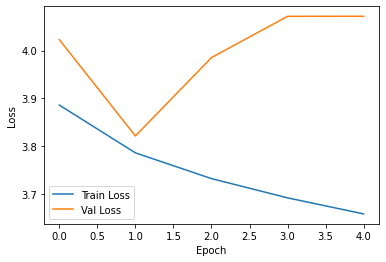

In [3]:
results_df = pd.DataFrame(columns=['lr','batch','sub','embedding_dim','window_size','val_loss'])
for sub in subs:
    ### embedding
    dataset = Embedding_Dataset(table_1, table_2, table_3)
    dataset_length = len(dataset)
    train_size = int(train_ratio * dataset_length)
    train_indices = range(0, train_size)
    val_size = int(val_ratio * dataset_length)
    val_indices = range(train_size, train_size + val_size)
    # test_size = int(test_ratio * dataset_length)
    # test_indices = range(train_size + val_size, dataset_length)
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    # test_dataset = Subset(dataset, test_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

    embedding_model = Embedding(128, 256, 512, embedding_dim, 512, 256, 128).to(DEVICE)
    criterion = RMSE()
    optimizer = torch.optim.Adam(embedding_model.parameters(), lr=lr)

    embedding_train_losses = []
    embedding_val_losses = []

    max_early_stop_count = 3
    early_stop_count = 0
    embedding_best_val_loss = float('inf')
    embedding_best_model_weights = None

    for epoch in range(epochs):
        embedding_model.train()
        embedding_total_train_loss = 0
        for data in train_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = embedding_model(input).to(DEVICE)

            embedding_train_loss = criterion(output, target)
            embedding_total_train_loss += embedding_train_loss.item()

            optimizer.zero_grad()
            embedding_train_loss.backward()
            optimizer.step()

        embedding_avg_train_loss = embedding_total_train_loss / len(train_dataloader)
        embedding_train_losses.append(embedding_avg_train_loss)

        embedding_model.eval()
        embedding_total_val_loss = 0
        with torch.no_grad():
            for data in val_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                output = embedding_model(input).to(DEVICE)

                embedding_val_loss = criterion(output, target)
                embedding_total_val_loss += embedding_val_loss.item()

        embedding_avg_val_loss = embedding_total_val_loss / len(val_dataloader)
        embedding_val_losses.append(embedding_avg_val_loss)

        if  embedding_best_val_loss > embedding_avg_val_loss:
            embedding_best_val_loss = embedding_avg_val_loss
            embedding_best_model_weights = copy.deepcopy(embedding_model.state_dict())
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= max_early_stop_count:
            print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f} \nEarly Stop Triggered!')
            embedding_model.load_state_dict(embedding_best_model_weights)
            torch.save(embedding_model, f'../데이터/Checkpoint/emb/embedding_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
            break

        print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f}')
        
    save_train_val_losses(embedding_train_losses, embedding_val_losses, f'../데이터/Checkpoint/emb/embedding_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

    ### transformer
    dataset = Apartment_Complex_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, 'DL', DEVICE)
    dataset_length = len(dataset)
    train_size = int(train_ratio * dataset_length)
    train_indices = range(0, train_size)
    val_size = int(val_ratio * dataset_length)
    val_indices = range(train_size, train_size + val_size)
    # test_size = int(test_ratio * dataset_length)
    # test_indices = range(train_size + val_size, dataset_length)
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    # test_dataset = Subset(dataset, test_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

    transformer_model = Transformer(embedding_dim, 1, 2, 2).to(DEVICE)
    criterion = RMSE()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

    transformer_train_losses = []
    transformer_val_losses = []

    max_early_stop_count = 3
    early_stop_count = 0
    transformer_best_val_loss = float('inf')
    transformer_best_model_weights = None

    for epoch in range(epochs):
        transformer_model.train()
        transformer_total_train_loss = 0
        transformer_total_train_num = 1e-9
        for data in train_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if (trg[0] != 0):
                transformer_total_train_num += 1

                src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                output = transformer_model(src, src_mask)

                transformer_train_loss = criterion(output[0], trg)
                transformer_total_train_loss += transformer_train_loss.item()

                optimizer.zero_grad()
                transformer_train_loss.backward()
                optimizer.step()
                
        transformer_avg_train_loss = transformer_total_train_loss / transformer_total_train_num
        transformer_train_losses.append(transformer_avg_train_loss)

        transformer_model.eval()
        transformer_total_val_loss = 0
        transformer_total_val_num = 1e-9
        with torch.no_grad():
            for data in val_dataloader:
                src = data[0].to(DEVICE)
                trg = data[1].to(DEVICE)

                if (trg[0] != 0):
                    transformer_total_val_num += 1

                    src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                    output = transformer_model(src, src_mask)

                    transformer_val_loss = criterion(output[0], trg)
                    transformer_total_val_loss += transformer_val_loss.item()

        transformer_avg_val_loss = transformer_total_val_loss / transformer_total_val_num
        transformer_val_losses.append(transformer_avg_val_loss)

        if  transformer_best_val_loss > transformer_avg_val_loss:
            transformer_best_val_loss = transformer_avg_val_loss
            transformer_best_model_weights = copy.deepcopy(transformer_model.state_dict())
            early_stop_count = 0
        else:
            early_stop_count += 1
            
        if early_stop_count >= max_early_stop_count:
            print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f} \nEarly Stop Triggered!')
            transformer_model.load_state_dict(transformer_best_model_weights)
            torch.save(transformer_model, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
            break

        print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f}')
    
    save_train_val_losses(transformer_train_losses, transformer_val_losses, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

    ### transformer attention
    dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
    dataset_length = len(dataset)
    train_size = int(train_ratio * dataset_length)
    train_indices = range(0, train_size)
    val_size = int(val_ratio * dataset_length)
    val_indices = range(train_size, train_size + val_size)
    # test_size = int(test_ratio * dataset_length)
    # test_indices = range(train_size + val_size, dataset_length)
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    # test_dataset = Subset(dataset, test_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

    transformer_att_model = TransformerAttention(transformer_model, embedding_dim, 1, DEVICE).to(DEVICE)
    criterion = RMSE()
    optimizer = torch.optim.Adam(transformer_att_model.parameters(), lr=lr)

    transformer_att_train_losses = []
    transformer_att_val_losses = []

    max_early_stop_count = 3
    early_stop_count = 0
    transformer_att_best_val_loss = float('inf')
    transformer_att_best_model_weights = None

    for epoch in range(epoch):
        transformer_att_model.train()
        transformer_att_total_train_loss = 0
        transformer_att_total_train_num = 1e-9
        for data in train_dataloader:
            src = data[0][0].to(DEVICE)
            max_len = data[1][0].to(DEVICE)
            anw = data[2][0].to(DEVICE)
            trg = data[3][0].to(DEVICE)
            
            if len(anw) == 0:
                continue
            
            transformer_att_total_train_num += len(anw)

            for index in anw:
                output = transformer_att_model(src, index, max_len)
                
                transformer_att_train_loss = criterion(output, trg[index])
                transformer_att_total_train_loss += transformer_att_train_loss.item()
                
                optimizer.zero_grad()
                transformer_att_train_loss.backward()
                optimizer.step() 
                
        transformer_att_avg_train_loss = transformer_att_total_train_loss / transformer_att_total_train_num
        transformer_att_train_losses.append(transformer_att_avg_train_loss)

        transformer_att_model.eval()
        transformer_att_total_val_loss = 0
        transformer_att_total_val_num = 1e-9
        with torch.no_grad():
            for data in val_dataloader:
                src = data[0][0].to(DEVICE)
                max_len = data[1][0].to(DEVICE)
                anw = data[2][0].to(DEVICE)
                trg = data[3][0].to(DEVICE)

                if len(anw) == 0:
                    continue
                
                transformer_att_total_val_num += len(anw)

                for index in anw:
                    output = transformer_att_model(src, index, max_len)

                    transformer_att_val_loss = criterion(output, trg[index])
                    transformer_att_total_val_loss += transformer_att_val_loss.item()
                    
        transformer_att_avg_val_loss = transformer_att_total_val_loss / transformer_att_total_val_num
        transformer_att_val_losses.append(transformer_att_avg_val_loss)
                
        if  transformer_att_best_val_loss > transformer_att_avg_val_loss:
            transformer_att_best_val_loss = transformer_att_avg_val_loss
            transformer_att_best_model_weights = copy.deepcopy(transformer_att_model.state_dict())
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= max_early_stop_count:
            print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f} \nEarly Stop Triggered!')
            transformer_att_model.load_state_dict(transformer_att_best_model_weights)
            torch.save(transformer_att_model, f'../데이터/Checkpoint/attention/attention_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
            break

        print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f}')

    save_train_val_losses(transformer_att_train_losses, transformer_att_val_losses, f'../데이터/Checkpoint/attention/attention_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

    results_df = results_df.append({
        'lr': lr,
        'batch': batch,
        'sub': sub,
        'embedding_dim': embedding_dim,
        'window_size': window_size,
        'val_loss': min(transformer_att_val_losses),
    }, ignore_index=True)

results_df.to_excel('../데이터/Checkpoint/experiment_results.xlsx')

### test

In [ ]:
transformer_att_model

In [ ]:
# transformer attention
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_att_model.eval()
transformer_att_total_test_rmse = 0
transformer_att_total_test_mse = 0
transformer_att_total_test_mae = 0
transformer_att_total_test_mape = 0
transformer_att_total_test_num = 1e-9
with torch.no_grad():
    for data in test_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        anw = data[2][0].to(DEVICE)
        trg = data[3][0].to(DEVICE)

        if len(anw) == 0:
            continue

        transformer_att_total_test_num += len(anw)

        for index in anw:
            output = transformer_att_model(src, index, max_len)

            transformer_att_test_rmse = rmse(output, trg[index])
            transformer_att_test_mse = mse(output, trg[index])
            transformer_att_test_mae = mae(output, trg[index])
            transformer_att_test_mape = mape(output, trg[index])
            
            transformer_att_total_test_rmse += transformer_att_test_rmse.item()
            transformer_att_total_test_mse += transformer_att_test_mse.item()
            transformer_att_total_test_mae += transformer_att_test_mae.item()
            transformer_att_total_test_mape += transformer_att_test_mape.item()
            
transformer_att_avg_test_rmse = transformer_att_total_test_rmse / transformer_att_total_test_num
transformer_att_avg_test_mse = transformer_att_total_test_mse / transformer_att_total_test_num
transformer_att_avg_test_mae = transformer_att_total_test_mae / transformer_att_total_test_num
transformer_att_avg_test_mape = transformer_att_total_test_mape / transformer_att_total_test_num
        
print(f'Test RMSE: {transformer_att_avg_test_rmse}')
print(f'Test MSE: {transformer_att_avg_test_mse}')
print(f'Test MAE: {transformer_att_avg_test_mae}')
print(f'Test MAPE: {transformer_att_avg_test_mape}')